#Waymo Open Dataset 2D Panoramic Video Panoptic Segmentation Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to decode and interpret the 2D panoramic video panoptic segmentation labels. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

## Dataset
This dataset contains panoptic segmentation labels for a subset of the Open
Dataset camera images. In addition, we provide associations for instances between different camera images and over time, allowing for panoramic video panoptic segmentation.

For the training set, we provide tracked sequences of 5 temporal frames, spaced at t=[0ms, 400ms, 600ms, 800ms, 1200ms]. For each labeled time step, we  label all 5 cameras around the Waymo vehicle, resulting in a total of 25 labeled images per sequence. This allows for tracking over a variety of different time frames and viewpoints.

For the validation set, we label entire run segments at 5Hz (every other image), resulting in sequences of 100 temporal frames over 5 cameras (500 labels per sequence).

## Instructions
This colab will demonstrate how to read the labels, and to extract panoptic labels with consistent instance ID tracks for any number of frames.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



# Package Installation

Package installation
Please follow the instructions in [tutorial.ipynb](https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb).

# Imports and global definitions

In [5]:
# Data location. Please edit.

# A tfrecord containing tf.Example protos as downloaded from the Waymo dataset
# webpage.

# Replace this path with your own tfrecords.
import os
print(os.getcwd())
os.chdir('../../waymo-open-dataset/')
print(os.getcwd())
FILE_NAME = 'tutorial/individual_files_training_segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord'

/home/airlab-jmw/pyws/waymo-open-dataset/tutorial
/home/airlab-jmw/pyws/waymo-open-dataset


In [10]:
import immutabledict
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

if not tf.executing_eagerly():
  tf.compat.v1.enable_eager_execution()

from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.utils import camera_segmentation_utils

# Read 2D panoptic segmentation labels from Frame proto
Note that only a subset of the frames have 2D panoptic labels.

In [11]:
dataset = tf.data.TFRecordDataset(FILE_NAME, compression_type='')
frames_with_seg = []
sequence_id = None
for data in dataset:
  frame = open_dataset.Frame()
  frame.ParseFromString(bytearray(data.numpy()))
  # Save frames which contain CameraSegmentationLabel messages. We assume that
  # if the first image has segmentation labels, all images in this frame will.
  if frame.images[0].camera_segmentation_label.panoptic_label:
    frames_with_seg.append(frame)
    if sequence_id is None:
      sequence_id = frame.images[0].camera_segmentation_label.sequence_id
    # Collect 3 frames for this demo. However, any number can be used in practice.
    if frame.images[0].camera_segmentation_label.sequence_id != sequence_id or len(frames_with_seg) > 2:
      break

In [12]:
# Organize the segmentation labels in order from left to right for viz later.
camera_left_to_right_order = [open_dataset.CameraName.SIDE_LEFT,
                              open_dataset.CameraName.FRONT_LEFT,
                              open_dataset.CameraName.FRONT,
                              open_dataset.CameraName.FRONT_RIGHT,
                              open_dataset.CameraName.SIDE_RIGHT]
segmentation_protos_ordered = []
for frame in frames_with_seg:
  segmentation_proto_dict = {image.name : image.camera_segmentation_label for image in frame.images}
  segmentation_protos_ordered.append([segmentation_proto_dict[name] for name in camera_left_to_right_order])

# Read a single panoptic label

In [16]:
# Decode a single panoptic label.
panoptic_label_front = camera_segmentation_utils.decode_single_panoptic_label_from_proto(
    segmentation_protos_ordered[0][open_dataset.CameraName.FRONT]
)

# Separate the panoptic label into semantic and instance labels.
semantic_label_front, instance_label_front = camera_segmentation_utils.decode_semantic_and_instance_labels_from_panoptic_label(
    panoptic_label_front,
    segmentation_protos_ordered[0][open_dataset.CameraName.FRONT].panoptic_label_divisor
)

# Read panoptic labels with consistent instance IDs over cameras and time

In [17]:
# The dataset provides tracking for instances between cameras and over time.
# By setting remap_values=True, this function will remap the instance IDs in
# each image so that instances for the same object will have the same ID between
# different cameras and over time.
segmentation_protos_flat = sum(segmentation_protos_ordered, [])
panoptic_labels, is_tracked_masks, panoptic_label_divisor = camera_segmentation_utils.decode_multi_frame_panoptic_labels_from_protos(
    segmentation_protos_flat, remap_values=True
)

# We can further separate the semantic and instance labels from the panoptic
# labels.
NUM_CAMERA_FRAMES = 5
semantic_labels_multiframe = []
instance_labels_multiframe = []
for i in range(0, len(segmentation_protos_flat), NUM_CAMERA_FRAMES):
  semantic_labels = []
  instance_labels = []
  for j in range(NUM_CAMERA_FRAMES):
    semantic_label, instance_label = camera_segmentation_utils.decode_semantic_and_instance_labels_from_panoptic_label(
      panoptic_labels[i + j], panoptic_label_divisor)
    semantic_labels.append(semantic_label)
    instance_labels.append(instance_label)
  semantic_labels_multiframe.append(semantic_labels)
  instance_labels_multiframe.append(instance_labels)

# Visualize the panoptic segmentation labels

In [18]:
def _pad_to_common_shape(label):
  return np.pad(label, [[1280 - label.shape[0], 0], [0, 0], [0, 0]])

# Pad labels to a common size so that they can be concatenated.
instance_labels = [[_pad_to_common_shape(label) for label in instance_labels] for instance_labels in instance_labels_multiframe]
semantic_labels = [[_pad_to_common_shape(label) for label in semantic_labels] for semantic_labels in semantic_labels_multiframe]
instance_labels = [np.concatenate(label, axis=1) for label in instance_labels]
semantic_labels = [np.concatenate(label, axis=1) for label in semantic_labels]

instance_label_concat = np.concatenate(instance_labels, axis=0)
semantic_label_concat = np.concatenate(semantic_labels, axis=0)
panoptic_label_rgb = camera_segmentation_utils.panoptic_label_to_rgb(
    semantic_label_concat, instance_label_concat)

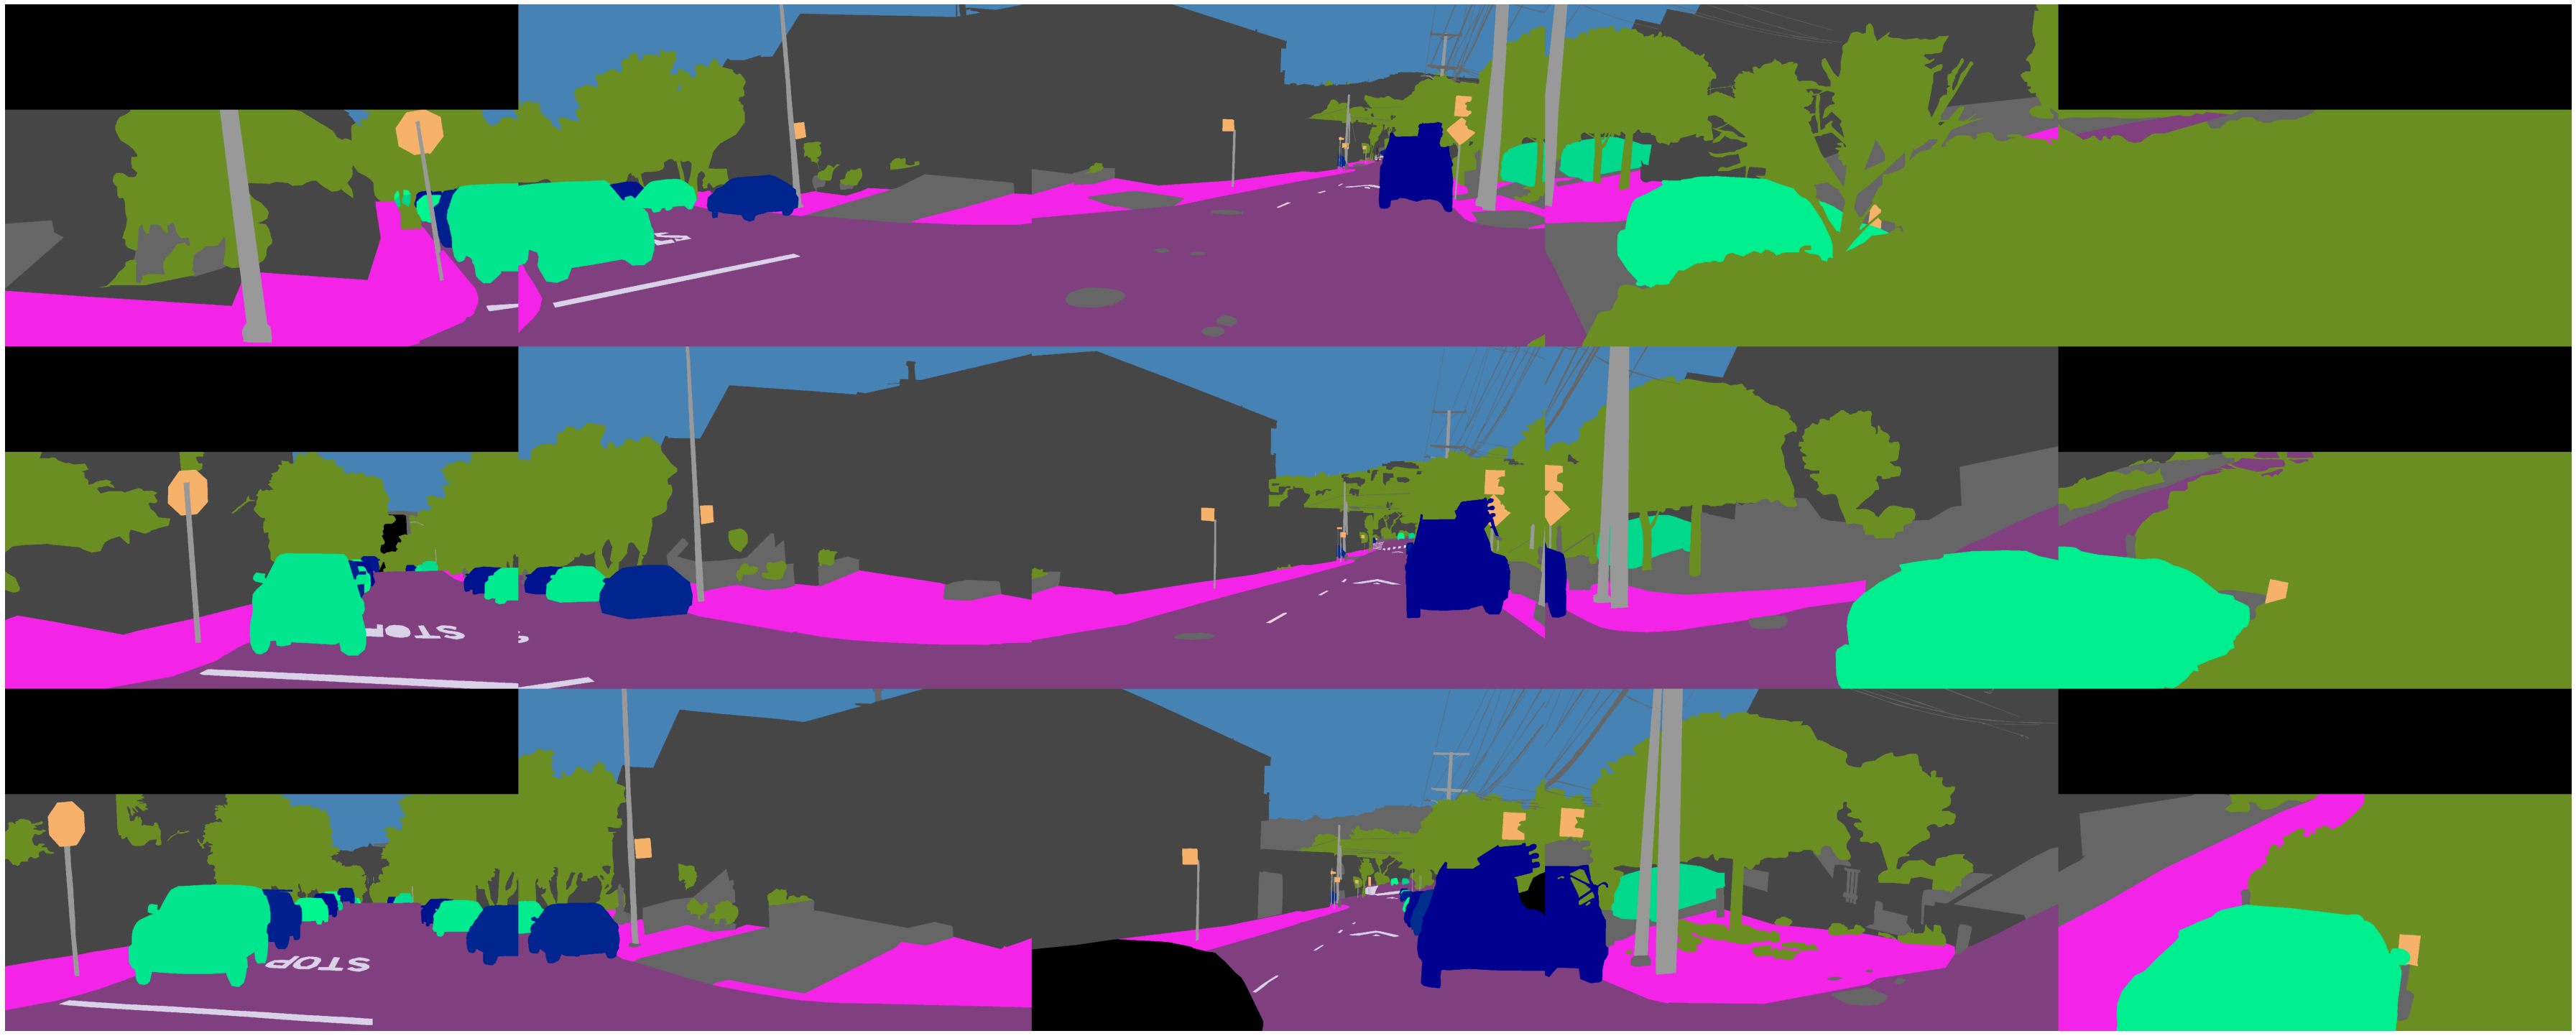

In [19]:
plt.figure(figsize=(64, 60))
plt.imshow(panoptic_label_rgb)
plt.grid(False)
plt.axis('off')
plt.show()